1. เลือก features และกำหนด Target จากช่วงเวลา 7/6/2021-26/9/2021
```
'actuals.positiveTests',
'actuals.negativeTests',
'actuals.vaccinationsInitiated',
'actuals.vaccinationsCompleted',
'metrics.testPositivityRatio',
'metrics.vaccinationsInitiatedRatio',
'metrics.vaccinationsCompletedRatio',
'DoW',
'Positivity rate'
Target = 'actuals.newCases'

2. Normalize Data ให้มีค่าระหว่าง 0-1

3. Window Size ย้อนหลัง 14 วัน  เพื่อทำนาย 7 วันข้างหน้า
```
total sample =  111  
train size = 90
test size = 21


4. เทรนแยกรัฐ ด้วยโมเดล 1D CNN
```
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
```

5. Evaluation ด้วย root mean square error ครับผม

In [ ]:
# multivariate multi-step 1d cnn example
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from func1 import *
# from query2 import *
import pandas as pd
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (25,10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls 'drive/MyDrive/covid'

0.csv  1.csv  2.csv  3.csv  4.csv  5.csv  6.csv
0.png  1.png  2.png  3.png  4.png  5.png  6.png


In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
def split_sequences_2(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequences):
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

def ShallowConvNet(n_steps_in, n_steps_out, n_features):
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(50, activation='relu'))
	model.add(Dense(n_steps_out))
	return model

In [ ]:
# df = pd.read_csv('/content/COVID_data_for_ML.csv')
df = pd.read_csv('/content/historical_states_LSTM_by_state.csv')

ABC = pd.unique(df['state'])
ABC_list = ABC.tolist()
from google.colab import files
j=0
array_A = []
for i in ABC_list:
  df_one_state = df[df.state == i]
  df_one_state.replace({"#DIV/0!": None},inplace=True)
  df_one_state.fillna(method="ffill", inplace=True)
  df_one_state['date'] = pd.to_datetime(df_one_state['date'])
  df_one_state['DoW'] = df_one_state['date'].dt.dayofweek
  df_one_state['Positivity rate'] = pd.to_numeric(df_one_state['Positivity rate'])
  df_one_state['ratio_bed'] = pd.to_numeric(df_one_state['ratio_bed'])
  start_date = '2021-6-7' 
  end_date = '2021-9-26'
  mask = (df_one_state['date'] > start_date) & (df_one_state['date'] <= end_date)
  df_one_state = df_one_state.loc[mask]
  df_one_state.drop(columns=['date','state','ratio_bed'],inplace=True)
  selected_column = ['actuals.positiveTests', 'actuals.negativeTests',
       'actuals.vaccinationsInitiated',
       'actuals.vaccinationsCompleted', 'metrics.testPositivityRatio',
       'metrics.vaccinationsInitiatedRatio',
       'metrics.vaccinationsCompletedRatio', 'DoW','actuals.newCases','Positivity rate']
  df_one_state = df_one_state[selected_column]
  array_A.append(df_one_state)

In [ ]:
# np.array(array_A[0]['actuals.newCases'][90:]).reshape(-1,1).shape

In [ ]:
np.array(array_A[0]['actuals.newCases'][90:]).reshape(-1,1)

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 0s 115ms/step - loss: 0.1040 - val_loss: 0.2790
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0472 - val_loss: 0.1794
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0282 - val_loss: 0.1377
Epoch 4/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0215 - val_loss: 0.1222
Epoch 5/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.0192 - val_loss: 0.1122
Epoch 6/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0174 - val_loss: 0.1022
Epoch 7/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.0158 - val_loss: 0.0966
Epoch 8/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.0152 - val_loss: 0.0929
Epoch 9/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0149 - val_loss: 0.091

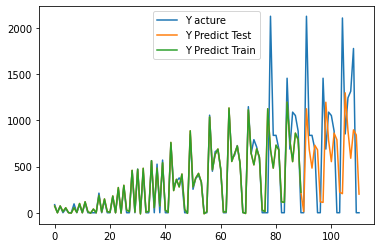

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 0s 108ms/step - loss: 0.0688 - val_loss: 0.0352
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0321 - val_loss: 0.0509
Epoch 3/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0241 - val_loss: 0.0852
Epoch 4/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0259 - val_loss: 0.0740
Epoch 5/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0240 - val_loss: 0.0497
Epoch 6/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0220 - val_loss: 0.0341
Epoch 7/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0211 - val_loss: 0.0274
Epoch 8/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0203 - val_loss: 0.0278
Epoch 9/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0195 - val_loss: 0.032

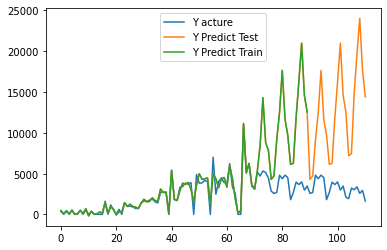

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 0s 117ms/step - loss: 0.2323 - val_loss: 0.0923
Epoch 2/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.1329 - val_loss: 0.1045
Epoch 3/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0771 - val_loss: 0.2227
Epoch 4/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0628 - val_loss: 0.3272
Epoch 5/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0652 - val_loss: 0.3098
Epoch 6/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0582 - val_loss: 0.2309
Epoch 7/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0474 - val_loss: 0.1647
Epoch 8/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0438 - val_loss: 0.1253
Epoch 9/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0451 - val_loss: 0.104

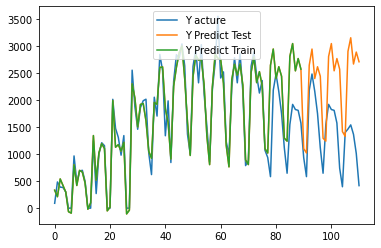

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 0s 135ms/step - loss: 0.1260 - val_loss: 0.0921
Epoch 2/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0559 - val_loss: 0.0273
Epoch 3/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 4/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0181 - val_loss: 0.0399
Epoch 5/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.0212 - val_loss: 0.0472
Epoch 6/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0217 - val_loss: 0.0413
Epoch 7/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0193 - val_loss: 0.0312
Epoch 8/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0171 - val_loss: 0.0221
Epoch 9/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0155 - val_loss: 0.015

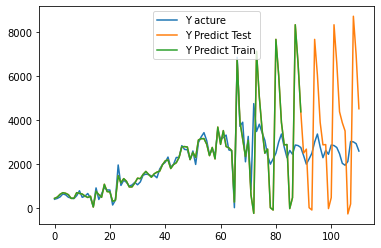

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 157ms/step - loss: 0.2410 - val_loss: 0.0775
Epoch 2/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1070 - val_loss: 0.0308
Epoch 3/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0566 - val_loss: 0.0290
Epoch 4/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0428 - val_loss: 0.0480
Epoch 5/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0467 - val_loss: 0.0641
Epoch 6/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0513 - val_loss: 0.0563
Epoch 7/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0453 - val_loss: 0.0423
Epoch 8/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0373 - val_loss: 0.0305
Epoch 9/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0316 - val_loss: 0.022

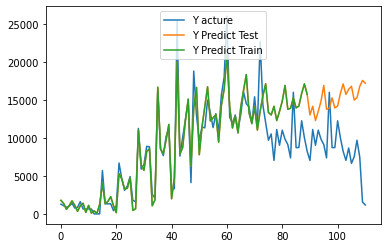

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 458ms/step - loss: 0.1153 - val_loss: 0.2560
Epoch 2/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0702 - val_loss: 0.1756
Epoch 3/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0445 - val_loss: 0.1249
Epoch 4/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0322 - val_loss: 0.0971
Epoch 5/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0263 - val_loss: 0.0835
Epoch 6/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0243 - val_loss: 0.0766
Epoch 7/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0230 - val_loss: 0.0733
Epoch 8/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0216 - val_loss: 0.0712
Epoch 9/1000
2/2 [==============================] - 0s 22ms/step - loss: 0.0200 - val_loss: 0.070

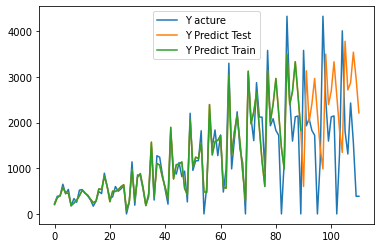

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 167ms/step - loss: 0.1053 - val_loss: 0.1520
Epoch 2/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0670 - val_loss: 0.1230
Epoch 3/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0578 - val_loss: 0.1208
Epoch 4/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0558 - val_loss: 0.1181
Epoch 5/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0521 - val_loss: 0.1138
Epoch 6/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0483 - val_loss: 0.1102
Epoch 7/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0447 - val_loss: 0.1083
Epoch 8/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0420 - val_loss: 0.1094
Epoch 9/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0409 - val_loss: 0.110

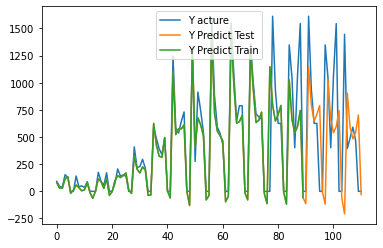

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 180ms/step - loss: 0.0524 - val_loss: 0.1482
Epoch 2/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0393 - val_loss: 0.1260
Epoch 3/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0342 - val_loss: 0.1024
Epoch 4/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0302 - val_loss: 0.0945
Epoch 5/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0300 - val_loss: 0.0926
Epoch 6/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0293 - val_loss: 0.0911
Epoch 7/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0281 - val_loss: 0.0909
Epoch 8/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0265 - val_loss: 0.0894
Epoch 9/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0246 - val_loss: 0.089

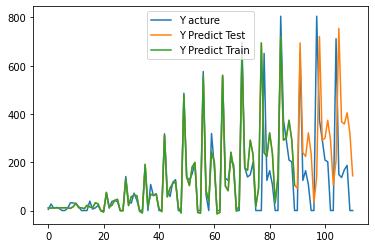

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 164ms/step - loss: 0.1038 - val_loss: 0.2806
Epoch 2/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0611 - val_loss: 0.1771
Epoch 3/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0430 - val_loss: 0.1124
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0327 - val_loss: 0.0778
Epoch 5/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0278 - val_loss: 0.0645
Epoch 6/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0259 - val_loss: 0.0615
Epoch 7/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0253 - val_loss: 0.0605
Epoch 8/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0234 - val_loss: 0.0565
Epoch 9/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0199 - val_loss: 0.051

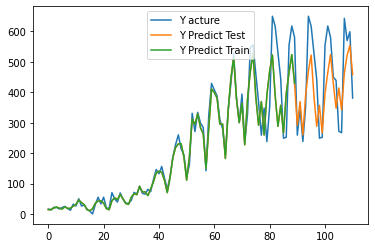

raw of shape  (111, 10)
dropna  (111, 10)
X_train (90, 14, 9)
X_test (2, 14, 9)
y_train (90, 7)
y_test (2, 7)
Epoch 1/1000
2/2 [==============================] - 1s 167ms/step - loss: 0.1791 - val_loss: 0.0741
Epoch 2/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0976 - val_loss: 0.0844
Epoch 3/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0710 - val_loss: 0.1522
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0728 - val_loss: 0.1815
Epoch 5/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0733 - val_loss: 0.1634
Epoch 6/1000
2/2 [==============================] - 0s 23ms/step - loss: 0.0661 - val_loss: 0.1310
Epoch 7/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0597 - val_loss: 0.1054
Epoch 8/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0576 - val_loss: 0.0928
Epoch 9/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.0580 - val_loss: 0.088

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import files

for i in range(0,52):
  df = array_A[i].copy()
  print("raw of shape ", df.shape)
  df.sort_index(inplace=True)
  df.dropna(inplace=True)
  print("dropna ", df.shape)

  from sklearn.preprocessing import MinMaxScaler
  y_scaler = MinMaxScaler()
  y_scaler.fit(df[['actuals.newCases']])
  X_scaler = MinMaxScaler()

  df[['actuals.positiveTests', 'actuals.negativeTests',
        'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
        'metrics.testPositivityRatio', 'metrics.vaccinationsInitiatedRatio',
        'metrics.vaccinationsCompletedRatio', 'DoW',
        'Positivity rate','actuals.newCases']] = X_scaler.fit_transform(df)

  dfval = df.values
  n_steps_in, n_steps_out = 14, 7
  X, y = split_sequences(dfval, n_steps_in, n_steps_out)

  X_train = X[:90,:]
  X_test = X[90:,:]
  y_train = y[:90,:]
  y_test = y[90:,:]

  print('X_train', X_train.shape) 
  print('X_test', X_test.shape) # (390, 10, 31) = (samples, n_steps_in, n_features)
  print('y_train',y_train.shape) # (4000, 7) = (samples, n_steps_out)
  print('y_test',y_test.shape) # (390, 7) = (samples, n_steps_out)
  n_features = X.shape[2]

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')

  save_path = 'models/'
  filepath=save_path+"m{epoch:02d}.hdf5"
  checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=0, save_best_only=True)
  history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=1000, verbose=1, callbacks=[checkpointer])

  print(history.history.keys())
  print(np.argmin(np.array(history.history['val_loss']))+1)
  yhat = model.predict(X_train, verbose=1)
  yp_train = y_scaler.inverse_transform(yhat)
  ya_train = y_scaler.inverse_transform(y_train)

  print(history.history.keys())
  print(np.argmin(np.array(history.history['val_loss']))+1)

  xtest_new = dfval[90-14:, :-1]
  opopx,opy = split_sequences_2(xtest_new, 14, 1)
  yhat = model.predict(opopx, verbose=1)
  yp_test = y_scaler.inverse_transform(yhat)

  ytest_new = np.array(array_A[i]['actuals.newCases'][90:]).reshape(-1,1)
  YA = np.concatenate((ya_train[:,:1] , ytest_new))
  YPred = np.concatenate((yp_train[:,:1] , yp_test[:,:1]))

  # ytest_new = dfval[90:, -1:]
  # ytest_new = y_scaler.inverse_transform(ytest_new)

  rms = sqrt(mean_squared_error(YPred, YA))
  rms_total = rms*100
  print('rmse',rms_total)

  dataset = pd.DataFrame(np.concatenate((YPred,YA),axis = 1), columns=['pred','act'])
  dataset.to_csv('drive/MyDrive/covid/'+str(i)+'.csv')
  # files.download('drive/MyDrive/covid'+str(i)+'.csv')

  plt.plot(YA, label='Y acture')
  plt.plot(YPred, label='Y Predict Test')
  plt.plot(yp_train[:,:1], label='Y Predict Train')
  plt.legend(loc="upper center")
  plt.savefig('drive/MyDrive/covid/'+str(i)+".png")
  plt.show()